In [1]:
%matplotlib inline


# NWS Precipitation Map


Plot a 1-day precipitation map using a netCDF file from the National Weather Service.

This opens the data directly in memory using the support in the netCDF library to open
from an existing memory buffer. In addition to CartoPy and Matplotlib, this uses
a custom colortable as well as MetPy's unit support.



Imports



In [5]:
from datetime import datetime, timedelta
from urllib.request import urlopen

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from metpy.units import masked_array, units
from netCDF4 import Dataset
import os, sys

Download the data from the National Weather Service.



In [6]:
dt = datetime.utcnow() - timedelta(days=1)  # This should always be available
print(dt)
#dt = datetime(2019,2,19) - timedelta(days=1)
#print dt
url = 'http://water.weather.gov/precip/downloads/{dt:%Y/%m/%d}/nws_precip_1day_'\
      '{dt:%Y%m%d}_conus.nc'.format(dt=dt)
data = urlopen(url).read()
Dataset('temp.nc', 'w').close()  # Work around bug where it needs an existing netCDF file
nc = Dataset('temp.nc', 'r', memory=data)

2019-10-05 15:26:04.309441


In [7]:
nc.data_time

'20191005'

In [8]:
list(nc.variables)

['time',
 'crs',
 'observation',
 'normal',
 'departure_from_normal',
 'percent_of_normal',
 'x',
 'y']

In [9]:
nc.variables["observation"]

<class 'netCDF4._netCDF4.Variable'>
float32 observation(y, x)
    _FillValue: -3.4028235e+38
    proj4: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +x_0=0 +y_0=0 +a=6371200 +b=6371200 +units=m +no_defs
    grid_mapping: crs
    name: observation
    coordinates: time x y
    long_name: Observation
    units: Inches
    missing_value: -3.4028234663852886e+38
    esri_pe_string: PROJCS["NOAA_HRAP_Grid",    GEOGCS["GCS_NOAA_HRAP",        DATUM["D_NOAA_HRAP",            SPHEROID["Sphere",6371200,0.0]        ],        PRIMEM["Greenwich",0.0],        UNIT["Degree",0.0174532925199433]    ],    PROJECTION["Stereographic_North_Pole"],    PARAMETER["false_easting",0.0],    PARAMETER["false_northing",0.0],    PARAMETER["central_meridian",-105.0],    PARAMETER["standard_parallel_1",60.0],    UNIT["meter",1.0]]
unlimited dimensions: 
current shape = (881, 1121)
filling on

In [11]:
pwd

'C:\\Users\\admin\\Documents\\GitHub\\Weather-Jupyter-Notebooks\\Case-Studies'

In [12]:
now = datetime.utcnow() 
Year = now.year
Day = now.day
Hour = now.hour
Month = now.month 
Minute = now.minute

# Since the maps generally use formats like 06Z or 02-20-16, we need to make the integers into
# strings and concecanate(sp?) zeros where necessary. Ex: February = "2" but need "02"; "0"+"2" = "02"

if Day < 10:
    Day = "0"+str(Day)
if Hour < 10:
    Hour = "0"+str(Hour)
if Minute < 10:
    Minute = "0"+str(Minute)
if Month < 10:
    Month = "0"+str(Month)

    
today = datetime.now()
JulianDate = today.strftime('%j') 
print(JulianDate)

save_path ='C://Users//admin/Desktop/'+str(Month)+"_"+str(Day)+"/"
#save_path ="/Users/ChowdaHead/Desktop/UCAR/"
if not os.path.isdir(save_path):
    os.makedirs(save_path)
save_path

279


'C://Users//admin/Desktop/10_06/'

In [27]:
print(str(dt))
Time = str(dt)[:-9]
Time = Time[:-1].replace(":","")
Time = Time.replace(" ","-")
Time = Time.replace("-","_")
Time = Time+"Z"
print(Time)

2019-10-05 15:26:04.309441
2019_10_05_1526Z


Pull the needed information out of the netCDF file



In [14]:
prcpvar = nc.variables['observation']
data = masked_array(prcpvar[:], units(prcpvar.units.lower())).to('mm')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
proj_var = nc.variables[prcpvar.grid_mapping]

C:\Users\admin\Anaconda3\lib\site-packages\numpy\ma\core.py:1018: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


Set up the projection information within CartoPy



In [15]:
globe = ccrs.Globe(semimajor_axis=proj_var.earth_radius)
proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=proj_var.straight_vertical_longitude_from_pole,
                          true_scale_latitude=proj_var.standard_parallel, globe=globe)

Create the figure and plot the data
create figure and axes instances



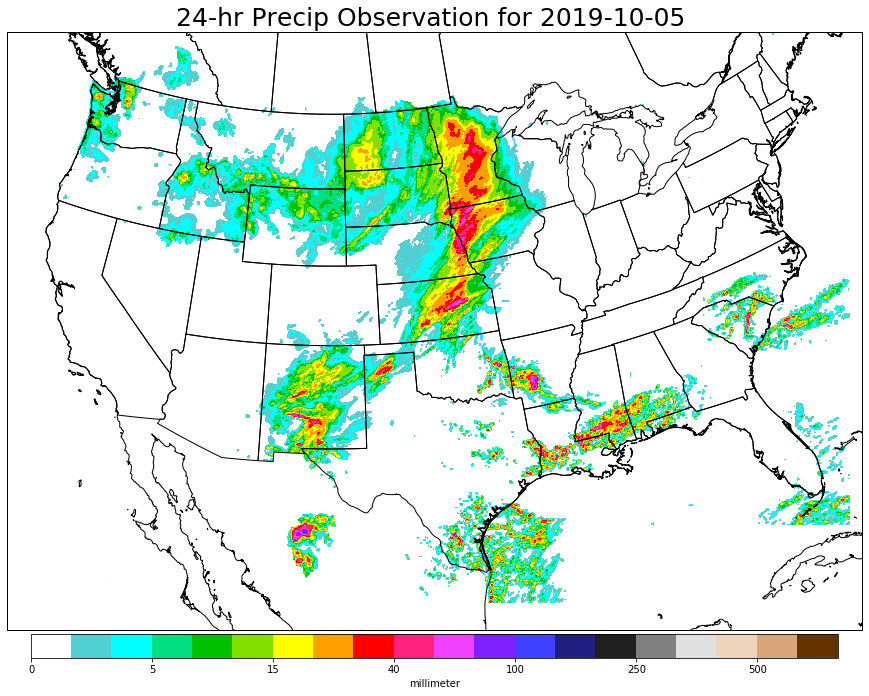

In [28]:
fig = plt.figure(figsize=(17.,11.))
ax = fig.add_subplot(1, 1, 1, projection=proj)
state_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                    name='admin_1_states_provinces_lakes',
                                                    scale='50m', facecolor='none')
# draw coastlines, state and country boundaries, edge of map.
#ax.coastlines()
#ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.STATES)
ax.coastlines('10m', color='black')
ax.add_feature(state_boundaries, edgecolor='black')


# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# In future MetPy
#norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

cs = ax.contourf(x, y, data, clevs, cmap=cmap, norm=norm)
ax.set_extent([-120, -80, 22, 50])

# add colorbar.
#cbaxes = fig.add_axes([0.865, 0.12, 0.03, 0.66]) # [left, bottom, width, height]
colorbar_axis = fig.add_axes([0.183, 0.09, 0.659, 0.03]) # [left, bottom, width, height]
cbar = plt.colorbar(cs, orientation='horizontal',cax=colorbar_axis)
cbar.set_label(data.units)

ax.set_title("24-hr Precip "+prcpvar.long_name + ' for ' + str(dt)[:-15],fontsize=25) #nc.creation_time
plt.show()

outfile=save_path+"Precip_"+Time
fig.savefig(outfile,bbox_inches='tight',dpi=120.)

In [12]:
str(dt)[:-9]

'2019-03-17 12:13:'

In [13]:
(dt - timedelta(days=1))

datetime.datetime(2019, 3, 16, 12, 13, 14, 933269)

In [14]:
DT = dt - timedelta(days=1)

In [15]:
str(DT)[:-9]

'2019-03-16 12:13:'